In [1]:
%matplotlib widget

In [2]:
import xtrack as xt

import matplotlib.pyplot as plt

In [25]:
line = xt.Line.from_json('../../xtrack/examples/fcc_ee_solenoid/fccee_z_with_sol.json')

Loading line from dict:   0%|          | 0/79095 [00:00<?, ?it/s]

Done loading line from dict.           


In [26]:
tw_sol_off = line.twiss4d()

Found suitable prebuilt kernel `default_only_xtrack`.
Found suitable prebuilt kernel `only_xtrack_frozen_energy`.


In [35]:
beam_sizes = tw_sol_off.get_beam_covariance(gemitt_x=250e-9, gemitt_y=1e-12)

In [38]:
beam_sizes.rows['ip.*'].cols['sigma_x sigma_y']

Table: 8 rows, 3 cols
name                     sigma_x     sigma_y
ip.4                 0.000165841 3.15363e-08
ip.5                 0.000165841 3.15363e-08
ip.6                 0.000165814  3.0785e-08
ip.7                 0.000165814  3.0785e-08
ip.1                  0.00016576 2.72331e-08
ip.2                 0.000165815 3.07778e-08
ip.3                 0.000165815 3.07778e-08
ip.4.l               0.000165841 3.15363e-08

In [27]:
line.vars['on_sol_ip.1'] = 1
tw_sol_on = line.twiss(method='4d')

In [28]:
tw_sol_on.c_minus

0.0003198462886154808

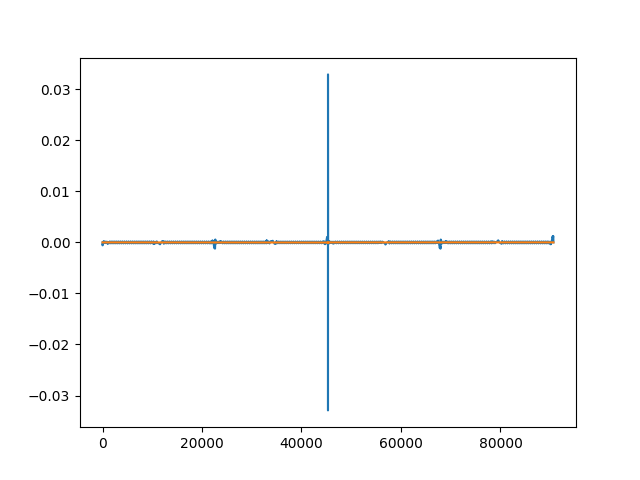

In [32]:
plt.figure()
plt.plot(tw_sol_on.s, tw_sol_on.x)
plt.plot(tw_sol_on.s, tw_sol_on.y)